# Schrodinger-equation-DNN

In this project, I am going to display the power of Deep Neural Networks (Auto-encoder architecture) to solve the 1D time-independent Schrödinger equation.

If a particle is subject to a known potential $\boldsymbol{V}(x)$, we need to find the find it's wave function $\boldsymbol{\psi}(\boldsymbol{x})$ that satisfies the following relation:

$$ \frac{-\hbar^2}{2m} \frac{\partial ^2 }{\partial x^2}\psi (x) +\boldsymbol{V}(x)\psi(x) = \boldsymbol{E} \psi(x)$$


We are going to create syntetic pontentials of the type $\boldsymbol{V}(x) = \boldsymbol{\Sigma}_i \boldsymbol{\alpha}_i x^i$ and we will use their analytical solution to train an autoecoder that will essentially learn a non-linear map between the potential  $\boldsymbol{V}(x)$ of a particle and the associated wave function $\boldsymbol{\psi}(x)$ of a particle.

We will use the trained network to solve the Schödinger equation for the 1-Dimensional quantum harmonic oscillator and we will compare it using the analytical solution:

$$\psi_n(x) = \left(\frac{1}{\sqrt{2^n n!}}\right) \left(\frac{m\omega}{\pi\hbar}\right)^{1/4} e^{-\frac{m\omega x^2}{2\hbar}} H_n\left(\sqrt{\frac{m\omega}{\hbar}}x\right)
$$



### Imports

In [4]:
import numpy as np
from pylab import *  # for plot
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema
import matplotlib
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
import tensorflow as tf
from tensorflow.keras import Model, layers

from sklearn.model_selection import train_test_split
#@title Energies as a function of N
#import plotly
#from plotly.graph_objs import graph_objs as go
#from plotly.subplots import make_subplots
#from plotly.offline import iplot


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Generate potentials and wave functions for a power series potential in basis of harmonic oscilator

In [58]:
class eigen_state_potential:
    def __init__(self, alpha_min=None, alpha_max=None, N=None, xmin=None, xmax=None):
        '''
        Class to generate data (V(x) and φ(x) ground state) for potentials of the form
        V(x) = sum_i alpha_i x^i, using the plane wave basis
        Args:
            alpha_min: vector of length N, with the minimum value of the coefficients alpha
            alpha_max: vector of length N, with the maximum value of the coefficients alpha
            the values of alpha will be randomly distributed in [alpha_min, alpha_max]
        '''
        if len(alpha_min)!=len(alpha_max):
            print("Error. Inconsisten shapes")
        self.alpha_min = np.array(alpha_min)
        self.alpha_max = np.array(alpha_max)
        self.N =N  # Length of plane wave basis
        self.k = len(alpha_min) #Number of alphas for V(x)
        self.xmin = xmin #xmin
        self.xmax = xmax #xmax
        #print(self.alpha_min,self.alpha_max,self.N,self.k,self.x_min,self.x_max)

    def delta(self,n,m):
        """
        Define the Dirac's delta
        """
        if(n==m):
            delta=1
        else:
            delta=0      
        return delta

    def find_eigen_state(self,alphas, n_state):
        '''
        Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
        Args:
            alphas(np array): size k. Coefficients of the potential V(x)
            n_state (int): Number of excited state (default n_state=0, ground state)
        Returns:
            E_a (float): Energy of the ground state for potential V
            a (np.array): size N. Coefficients in the basis of the H.O potential
        '''
        # 0. Generate matrix of C_nm
        N = self.N  # N==N
        xmin = self.xmin  # xmin
        xmax = self.xmax  # xmax

        T = np.zeros((N,N))
        delta_x=(xmax-xmin)/N
        L=delta_x*N
        mu=1.
        
        # 1. Build matrix T using the plane wave basis
#*********TODO***************
        for n in range(N):
            for m in range(N):
                if(n==m):
                    T[n,m] =(-1)**(n-m)*np.pi**2/(mu*L**2)*(N**2+2)/6
                elif(n!=m):
                    T[n,m] = (-1)**(n-m)*np.pi**2/(mu*L**2)*1./(np.sin(np.pi*(n-m)/N))**2


        # 2. Build matrix V
#*********TODO***************
        V = np.zeros((N,N))
        k = self.k  # k
        for n in range(N):
            x=xmin+n*delta_x
             #V[n,n]=0.5*x**2
            for i in range(k):
                V[n,n]+=alphas[i]*x**i

        # 3. Build matrix H
        H = np.zeros((N,N))
        veps= np.zeros((N,N))
        vaps=np.zeros(N)
        a= np.zeros((N,n_state+1))
        E_a=np.zeros(n_state+1)
        for n in range(N):
            for m in range(N):
                H[n,m] = T[n,m] + V[n,m]*self.delta(n,m)     

        # 4. Diagonalize matrix H
        vaps, veps = eigh(H)

        # 5. Set bound wave functions to be real and normalize them
        for n in range(N):
            norm=np.dot(veps[:,n],veps[:,n])
            macloc=np.argmax(abs(veps[:,n]))
            veps[:,n]=veps[:,n]*abs(veps[macloc,n])/veps[macloc,n]
            veps[:,n]=veps[:,n]/np.sqrt(delta_x*norm)

        # 6. We choose the vector with n_state-th lowest energy
        # as an approximation of the n_state state   
        a = veps[:,n_state] # Final value of eigenvalues for state n_state
        E_a =vaps[n_state] # Value of the energy
        return E_a, a

    def generate_data(self, n_samples, alpha=np.array([None]), n_state=None, display=100):
        '''
        Generates samples of potentials  with random coefficients and finds the n_state excited state for them
        Args:
            n_samples (int): Number of samples of potentials (alphas)
            alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
            n_state (int): Number of excited state (default n_state=0, ground state)
            display (int): Display step
        Returns:
            E (np.array): size n_samples. Ground energy for each V
            a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
            alpha (np.array): size n_samples x k. Coefficients of the potentials V(x)
        '''
        data = np.zeros((n_samples, self.N))

        # Generate random value of alphas
        if (alpha==None).any():
            print("Random alphas")
            r_alpha = np.random.random((n_samples, self.k)) # Values between 0 and 1
            alpha = r_alpha*(self.alpha_max - self.alpha_min)+ self.alpha_min # random alpha

        # Prepare vectors of energies and coefficients
        E = np.zeros(n_samples)
        a = np.zeros((n_samples, self.N))
        # Find ground state for each sample
        for i in range(n_samples):
            E_new, a_new = self.find_eigen_state(alpha[i,:], n_state)
            if i%display==0:
                print("\rGenerating data: {}/{}".format(i,n_samples), end='')
            E[i] = E_new
            a[i,:] = a_new
        return E, a, alpha  

    def evaluate_potential(self, xmin, xmax, N, alpha):
        '''
        Given the coeefficients alphas, it evaluates the potential in V(x)
        Args:
            xmin(float): minimum value of x
            xmax (float): maximum value of x
            N (int): Number of points between xmin and xmax
            alpha (np.array): size N x k. Matrix of coefficients of V(x) (each row a different potential)
        Returns:
            V(np.array): size n_samples x N. V(x) for every sample
            x(np.array): size N. Values of x
        '''
        x = np.arange(xmin, xmax, (xmax - xmin)/N)
        n_samples, k = alpha.shape
        V = np.zeros((n_samples, N))
        x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
        V = np.zeros((n_samples, N))# V(x) in each row different alpha
        for i in range(n_samples):
            for j in range(N):
                V[i,j] = np.dot(alpha[i,:],x_mat[:,j])

        return V, x

    def final_wavefunction(self, xmin, xmax, N, a):
        '''
        Returns the final wavefunctions psi(x) = sum_i alpha_i φ_i(x) for each alpha.
        Args:
            xmin(float): minimum value of x
            xmax (float): maximum value of x
            N (int): Number of points between xmin and xmax
            a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
        Returns:
            waves(np.array): size n_samples x N. psi(x) for each value of V (given by alpha)
        '''
        x = np.arange(xmin, xmax, (xmax - xmin)/N)
        n_samples, _ = a.shape
        # Construct matrix of φ_n   
        waves = np.zeros((n_samples, N))
        φs = np.zeros((n_samples, N))
        for i in range(n_samples):
            for j in range(N):
                waves[i,j] = a[i,j]
                φs[i,j] = waves[i,j]
                # convention: To choose the phase we make the maximums be first
            w = waves[i,:]
            maxi = argrelextrema(w, np.greater)[0]
            mini = argrelextrema(w, np.less)[0]
            idx2= np.abs(w[maxi])>5e-2
            maxi = maxi[idx2]
            idx2= np.abs(w[mini])>5e-2
            mini = mini[idx2]
            if len(maxi)==0 and len(mini)>0:
                waves[i,:] = -waves[i,:]
            elif len(mini)>0 and len(maxi)>0 and mini[0]<maxi[0]:
                waves[i,:] = -waves[i,:]
        return waves, x, φs

# Perform the simulation

In [55]:
xmin = -8
xmax = 8
n_state = 1
N = 200
n_samples=1000

# We generate the values of alpha
alpha_min = np.array([-150,-10,0.3,-0.1,0])/50
alpha_max = np.array([50,5,1.0,0.1,0.25])/50

k = alpha_min.shape[0]

r_alpha = np.random.random((int(n_samples*0.8), k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([-10,-1,0.1,0,0])
alpha_max2 = np.array([5,1,1.0,0,0])

r_alpha = np.random.random((int(n_samples*0.2), k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))
print(alpha)

# TODO generate the data from the eigen state potential
data_gen = eigen_state_potential(alpha_min, alpha_max, N, xmin, xmax)
    
# TODO Generate the energies, wavefunctions and potentials
E, a, alpha = data_gen.generate_data(n_samples = n_samples, alpha=alpha, n_state = n_state, display = 100)
waves, x, φs = data_gen.final_wavefunction(xmin, xmax, N, a)
V, _ = data_gen.evaluate_potential(xmin, xmax, N, alpha)
idx=-1

[[ 5.43980327e-01  5.29845529e-02  1.40953458e-02 -1.03080911e-03
   3.04140375e-03]
 [-2.29234534e+00  1.97144061e-03  1.93639755e-02  4.55825216e-04
   2.97615370e-03]
 [-1.75422923e+00 -1.50252293e-01  8.68481123e-03 -1.10067955e-03
   1.28523337e-03]
 ...
 [-9.46489117e+00  8.02318192e-01  7.51000927e-01  0.00000000e+00
   0.00000000e+00]
 [-4.83060329e+00  6.49951189e-01  9.37162055e-01  0.00000000e+00
   0.00000000e+00]
 [ 2.16383224e+00 -4.86414398e-01  4.24915378e-01  0.00000000e+00
   0.00000000e+00]]
Generating data: 900/1000

## Print some if the simulated data

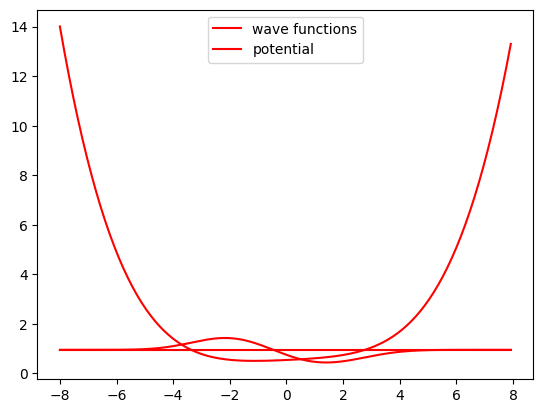

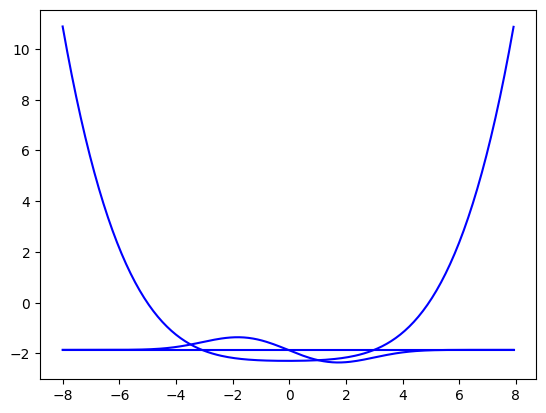

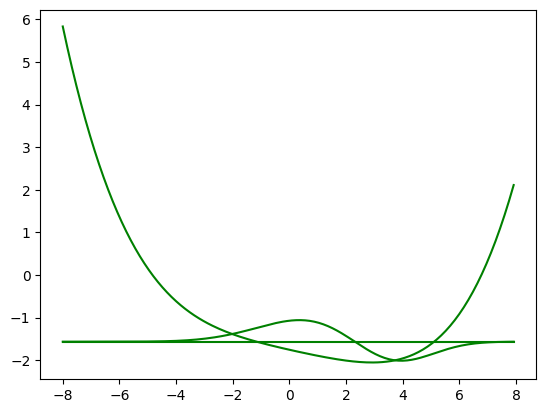

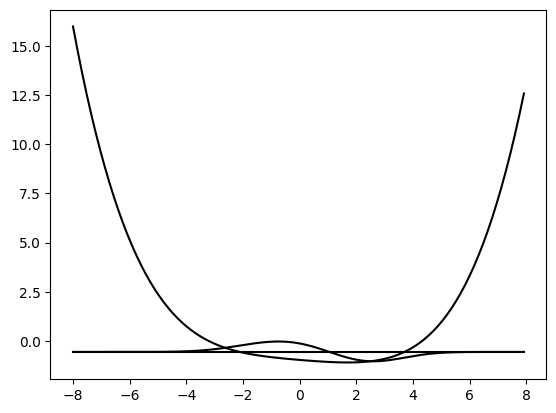

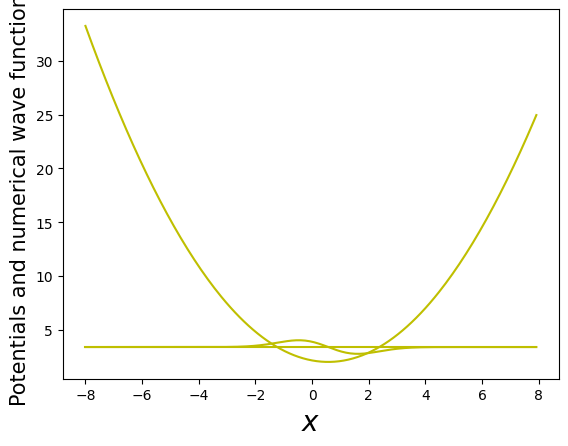

In [56]:
figure(1)
plot(x,waves[0,:]+E[0],'-r')
plot(x,V[0,:],'-r')
legend(["wave functions","potential"])

tmp_E=np.ones(N,float)
tmp_E=tmp_E*E[0]
plot(x,tmp_E,'-r')
show()


plot(x,waves[1,:]+E[1],'-b')
plot(x,V[1,:],'-b')

tmp_E=np.ones(N,float)
tmp_E=tmp_E*E[1]
plot(x,tmp_E,'-b')
show()


plot(x,waves[2,:]+E[2],'-g')
plot(x,V[2,:],'-g')

tmp_E=np.ones(N,float)
tmp_E=tmp_E*E[2]
plot(x,tmp_E,'-g')
show()


plot(x,waves[int(n_samples/2.),:]+E[int(n_samples/2.)],'-k')
plot(x,V[int(n_samples/2.),:],'-k')


tmp_E=np.ones(N,float)
tmp_E=tmp_E*E[int(n_samples/2.)]
plot(x,tmp_E,'-k')
show()


plot(x,waves[n_samples-1,:]+E[n_samples-1],'-y')
plot(x,V[n_samples-1,:],'-y')


tmp_E=np.ones(N,float)
tmp_E=tmp_E*E[n_samples-1]
plot(x,tmp_E,'-y')
xlabel("$x$",size=20)
ylabel("Potentials and numerical wave functions",size=15)
show()

## Generate Harmonic Oscillator solution

In [45]:
class Harmonic_Oscillator:
    '''
    Class to generate potential and wavefunctions of an harmonic oscillator.
    Attributes:
    omega_min (float): Minimum value of omega
    omega_max (float): Maximum value of omega
    x0_min (float): Minimum value of x0
    x0_max (float): Maximum value of x0
    hbar (float): h bar
    m (float): mass
    N (int): number of points of the grid
    omega (np.array): values of omega
    x0 (np.array): values of x0
    '''
    def __init__(self, omega_min = 0.001, omega_max = 1, x0_min = -0.5, x0_max = 0.5,
                     hbar = 1, m = 1, x_range = 0.8, N = 100):
        self.omega_min = omega_min # omega ~ U(omega_min, omega_max)
        self.omega_max = omega_max
        self.x0_min = x0_min
        self.x0_max = x0_max
        self.hbar = hbar
        self.m = m
        self.find_xrange(x_range) # x in [-3 smax, 3smax]
        self.N = N # Number of points of the grid 
        self.omega=None
        self.x0 = None

    def find_xrange(self, x_range):
        '''
        Find range of x values x \in [-x_range * sigma_max, + x_range * sigma_max]
        Args:
        x_range (float)
        '''
        smax = np.sqrt(self.hbar/(self.m*self.omega_min)) # Find sigma_max
        self.xmin = -x_range*smax
        self.xmax = x_range*smax

    def generate_omega(self, N):
        '''
        Generates new values of omega
        Args:
        N (int): number of samples
        '''
        if N==None:
            N = 100
        self.omega = np.random.uniform(self.omega_min, self.omega_max, N).reshape(-1,1)
        self.x0 = np.random.uniform(self.x0_min, self.x0_max, N).reshape(-1,1)
    
    def generate_data(self, N=None, n=None , new_omega=True):
        '''
        Generates N random data points from the energetic level n
        Args:
        N (int): number of samples
        n (int): energetic level
        new_omega (boolean): if True, new values of omega are generated
        Returns:
        φ_n (np.array): HO wavefunctions
        x (np.array): grid
        omega (np.array): omega values for each sample
        x0 (np.array): values of x0 for each sample
        potential (np.array): V(x)
        '''
        if new_omega or self.omega.any()==None or self.x0.any()==None:
            self.generate_omega(N)

        x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.N)
        sigma_inv = np.sqrt(self.m*self.omega/self.hbar).reshape(-1,1)
        ones = np.repeat(1, N)
        x_mat = np.tensordot(x, ones, axes=0).T
        all_x = (x_mat - self.x0)*sigma_inv # It is a matrix of dim (num_omega x num_x_points), 
        # where each row has the values of x times sqrt(m*omega/hbar. In each row we change the value of omega
        herm = eval_hermite(n, all_x) # H_n(x/sigma)
        exp = np.exp(- all_x**2/2) # Exponential term

        φ_n = exp*herm

        h = (self.xmax - self.xmin)/self.N
        C = 1./np.sqrt(np.sum(φ_n*φ_n*h, axis = 1)) #1/np.sqrt(2**n * math.factorial(int(n))) * np.sqrt(sigma_inv)# Normalization constant
        C = C.reshape(-1,1)
        φ_n = C*φ_n #exp*herm

        potential = (x_mat-self.x0)**2 * 1/2*self.m*self.omega**2

        return φ_n, x, self.omega, self.x0, potential

    def get_energy(self, n, omega=np.array([None])):
        '''
        Get theoretical energy
        Args:
        n (int): energetic level
        omega (np.array): values of omega
        Returns:
        E (np.array): energies
        '''
        if omega.any()==None:
            omega = self.omega
        E = self.hbar*omega*(n+1/2)
        return E.flatten()

## Define and train the autoencoder with tensorflow


In [47]:
class FC_Model(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function φ_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting φ_n(x) -> REGRESSION
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 256, n2= 256, n3=128, n4=128, drop=0.1, #n's are the neurons per layer
                 **kwargs):
        self.input_size = input_size
        super(FC_Model, self).__init__(name=name, **kwargs)

        # Fully connected layer.
        self.fc1 = tf.keras.layers.Dense(n1,  activation='relu') 
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout1 = tf.keras.layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = tf.keras.layers.Dense(n2,  activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout2 = tf.keras.layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc3 = tf.keras.layers.Dense(n3, activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout3 = tf.keras.layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc4 = tf.keras.layers.Dense(n4, activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout4 = tf.keras.layers.Dropout(rate=drop)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(self.input_size, activation ='linear') 

    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of φ_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size]))
        x = self.fc1(x) # x -> (g(1) o a(1))(x)
        x = self.dropout1(x, training=is_training)
        x = self.fc2(x)
        x = self.dropout2(x, training=is_training)
        x = self.fc3(x)
        x = self.dropout3(x, training=is_training)
        x = self.fc4(x)
        x = self.dropout4(x, training=is_training)
        out = self.out(x)
        return out

In [1]:
class Training():
    '''
    Performs the training of the autoencoder model using mean absolute error loss

    Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

    Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    '''
    def __init__(self, 
                 net, #fc_model
                 learning_rate, #alpha
                 training_iters, #max number of epochs
                 batch_size,
                 display_step, 
                 early_stopping=50, #if at a certain point, the validation loss is still growing for the next 50 epochs, you stop
                 filepath=None, 
                 restore =True):
        self.net = net
        self.learning_rate = learning_rate
        self.training_iters = training_iters
        self.batch_size = batch_size
        self.display_step = display_step
        self.stopping_step=0
        self.loss = tf.keras.losses.MeanSquaredError()
        self.early_stopping = early_stopping
        self.optimizer = tf.keras.optimizers.legacy.Adam(self.learning_rate) # WARNING: we are using the legacy Adam optimizer because of speed issues
        self.filepath = filepath
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
        self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)  
        if restore:
            self.ckpt.restore(self.manager.latest_checkpoint)
            if self.manager.latest_checkpoint:
                print("Restored from {}".format(self.manager.latest_checkpoint))
            else:
                print("Initializing from scratch.")

    def loss_val(self, x_val, y_val):
        '''
        Computes the validation loss 
        Args:
        x_val(tensor): batch of validation sample
        y_val (tensor): labels for validation
        Returns:
         val_loss(tensor): validation loss
        '''
        pred_val = self.net(x_val, False) #outside training mode, don't do dropout
        val_loss = self.loss(pred_val, y_val) #prediction, target
        return val_loss

    def early_stop(self, epoch, val_loss, stop):
        '''
        Assesses if we have to stop training
        Args:
         epoch (int): current epoch
         val_loss (tensor): current validation loss
         stop (bool): early stop parameter
        Returns:
         stop(bool): True if the models stops training, false if it continues training
         '''
        #Store best validation loss
        if epoch == 0:
            self.best_loss = val_loss
        else:
            if val_loss < self.best_loss:
                self.stopping_step = 0
                self.best_loss = val_loss
            else:
                #If the validation loss does not decrease, we increase the number of stopping steps
                self.stopping_step += 1
        #If such number reaches the maximum, we stop training
        if self.stopping_step == self.early_stopping:
            stop = True
            print('Early stopping was triggered ')
        return stop

    # Optimization process. 
    @tf.function()
    def run_optimization(self,x, y):
        '''
        Performs one step of the learning process. It calculates the loss function and
        appies backpropagation algorithm to update the weights.

        Args:
        x (tensor): Samples of training data used to train the model
        y (tensor): Labels for training data

        Returns:
        -
        '''
        # Wrap computation inside a GradientTape for automatic differentiation.
        with tf.GradientTape() as g: #track how gradient evolves
            # Forward pass.
            pred = self.net(x)
            # Compute loss.
            loss = self.loss(pred, y)

        # Variables to update, i.e. trainable variables.
        trainable_variables = self.net.trainable_variables

        # Compute gradients.
        gradients = g.gradient(loss, trainable_variables) #chain rule

        # Update W and b following gradients.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss
      
    #@tf.function
    def fit(self, X_train,y_train, X_test,y_test, save=True):
        '''
        Main fit function 

        Args:
          X_train (numpy array): Processed training data
          y_train (numpy array): Labels training data
          X_test (numpy array): Processed test data (validation)
          y_test (numpy array): Labels test data
          save (bool): If true, we save the weights at the end of the training
        Returns:
          -
          '''
        # Create train and test datasets
        # Use tf.data API to shuffle and batch data.
        train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
        train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1) #pick mini batches and shuffles


        test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size) 

        loss_batch = []
        val_loss_batch = []

        stop = False
        epoch = 0
        # Run training for the given number of steps (and while not early stopping).
        while epoch < self.training_iters and stop == False:
            for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
                #Apply backpropagation algorithm
                loss = self.run_optimization(batch_x_train, batch_y_train)
                loss_batch.append(loss.numpy())

                for (test_x, test_y) in test_data:
                    #Compute validation loss
                    val_loss = self.loss_val(test_x, test_y)
                    val_loss_batch.append(val_loss.numpy())

                    stop = self.early_stop(epoch, val_loss, stop)
                    epoch += 1

            #Display the result
            if epoch % self.display_step == 0:
                print('Epoch: ', epoch, "Validation loss: ", val_loss.numpy(), "Loss: ", loss.numpy())

        #Save the weights
        if save:
            save_path = self.manager.save()
            print("Saved checkpoint for step {}".format(save_path))    

NameError: name 'tf' is not defined

# Generate harmonic oscilator data

[[5.64120436e+00 5.53516629e+00 5.43013431e+00 ... 4.17508803e+00
  4.26724774e+00 4.36041354e+00]
 [1.24482061e+01 1.22128384e+01 1.19797172e+01 ... 9.45027137e+00
  9.65744961e+00 9.86687426e+00]
 [1.20464939e+01 1.18061254e+01 1.15681792e+01 ... 1.14590529e+01
  1.16958798e+01 1.19351291e+01]
 ...
 [2.62229391e+01 2.57242868e+01 2.52304214e+01 ... 2.04019618e+01
  2.08463046e+01 2.12954341e+01]
 [4.88868551e-03 4.78875249e-03 4.68985144e-03 ... 5.12519171e-03
  5.22855778e-03 5.33295583e-03]
 [2.42659089e+01 2.37916779e+01 2.33221267e+01 ... 2.11908742e+01
  2.16385664e+01 2.20909384e+01]]
omega =%f
 [0.39648457]


<function matplotlib.pyplot.show(close=None, block=None)>

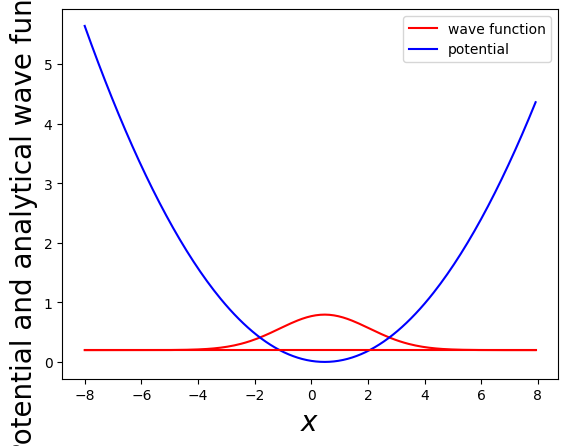

In [32]:
# TODO Generate H.O data
N = 200
n_state = 0


ho = Harmonic_Oscillator(N=N)
ho.xmax = 8
ho.xmin = -8

φ0_HO, x, omega, x0, potential_HO = ho.generate_data(N, n_state)
print(potential_HO)

#   plot
figure(3)
tmp_E=np.ones(N,float)
tmp_E=tmp_E*omega[0]*(1./2.+n_state)
print("omega =%f\n",omega[0])
plot(x,φ0_HO[0,:]+tmp_E[0],'-r')
plot(x,potential_HO[0,:],'-b')
plot(x,tmp_E,'-r')
legend(["wave function","potential"])
xlabel("$x$",size=20)
ylabel("Potential and analytical wave function",size=20)
show

### Train the encoder using the generated data

In [2]:
# Split train and test 
idx_train, idx_test, wave_train, wave_test = train_test_split(np.arange(V.shape[0]),
                                                              waves, test_size=0.33, random_state=69)
V_train = V[idx_train,:]
V_test = V[idx_test,:]

alpha_train = alpha[idx_train]
alpha_test = alpha[idx_test]  

# Parameters to train the neural network

learning_rate = 0.0001
training_iters = 1000
N = 300
batch_size = 100
display_step = 10
filepath ="models/"

NameError: name 'train_test_split' is not defined

In [28]:
fc_model = FC_Model(input_size=N)

# Train the model from scratch
train = Training(fc_model, 
                 learning_rate, 
                 training_iters, 
                 batch_size,
                 display_step, 
                 early_stopping=200, 
                 filepath=filepath, 
                 restore =True)
# Restore the model from previously trained weights
# train = Training(fc_model,learning_rate, training_iters, batch_size, display_step, 
#                  filepath=filepath,early_stopping=100, restore=True)

train.fit(V_train, wave_train, V_test, wave_test)

Restored from models/ckpt-1


2023-06-26 22:32:27.042331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-26 22:32:27.226981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-06-26 22:32:27.301367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Epoch:  4000 Validation loss:  0.008977027323639369 Loss:  0.0016927377480547789
Saved checkpoint for step models/ckpt-2


### Metrics on testing set

In [38]:
# MLP predictions
pred = fc_model(V_test,False)
print("Test MSE for polynomial potential: %f" % train.loss(pred, wave_test))        


Test MSE for polynomial potential: 0.002333
MSE(E) for polynomial potential:  1.094626305070801


## Comparing the solution of the autoencoder vs the analictycal solution of the harmonic oscillator

In [3]:
figure(5)
idx=0 #2
plot(x,pred.numpy()[idx,:]+E_emp[idx],'-r')
plot(x,wave_test[idx,:]+E[idx],'-b') #real φ
plot(x,V_test[idx,:],'-k')         #Potential
legend(["predicted wave function","real wave function","potential"])
xlabel("$x$",size=20)
ylabel("Real and predicted wave function on the potential",size=15)

NameError: name 'figure' is not defined

Text(0.5, 1.0, 'Energies for polynomial potential')

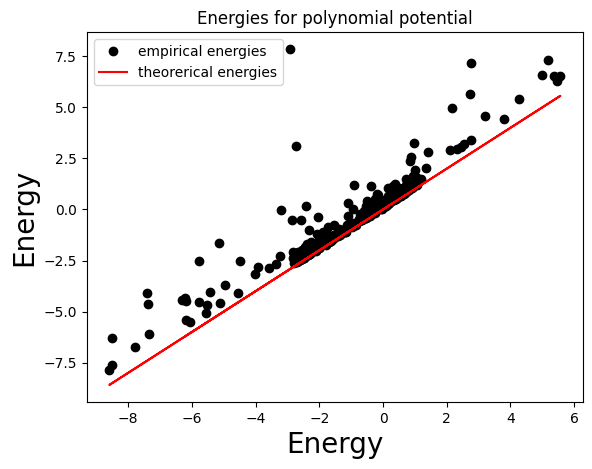

In [41]:
# plot Real and predicted mean energies
figure(6)
plot(E,E_emp,'ok') #empirical
plot(E,E,'-r') #theorerical
legend(["empirical energies","theorerical energies"])
xlabel("Energy",size=20)
ylabel("Energy",size=20)
title("Energies for polynomial potential")

In [22]:
# Test with HO
# Predict wavefunctions 
pred_HO = fc_model(potential_HO,False)
print("Test MSE for HO: %f" % train.loss(pred_HO, φ0_HO))
E = empirical_energy1D(φ0_HO, potential_HO)
E_emp = empirical_energy1D(pred_HO, potential_HO)
print('MSE(E) for HO: ', np.mean((E - E_emp)**2))

2023-06-26 22:27:24.740281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MSE for HO: 0.119263
MSE(E) for HO:  6.4329421385231935


Text(0, 0.5, 'Real and predicted wave function on the harmonic potential')

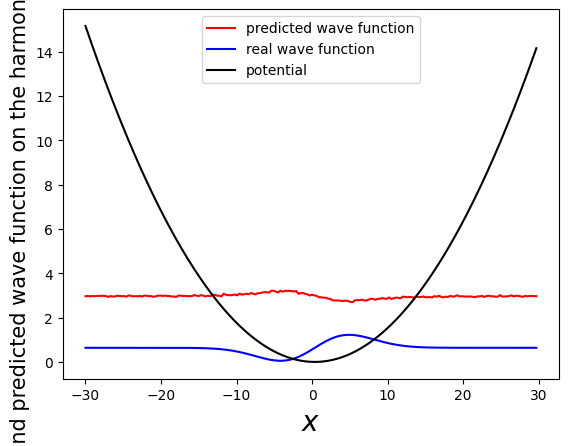

In [23]:
figure(7)
idx = 0 #1
plot(x,pred_HO.numpy()[idx,:]+E_emp[idx],'-r') #prediction φ
plot(x,φ0_HO[idx,:]+E[idx],'-b') #real φ
plot(x,potential_HO[idx,:],'-k') #Potential
legend(["predicted wave function","real wave function","potential"])
xlabel("$x$",size=20)
ylabel("Real and predicted wave function on the harmonic potential",size=15)

Text(0.5, 1.0, 'Energies for harmonic oscillator')

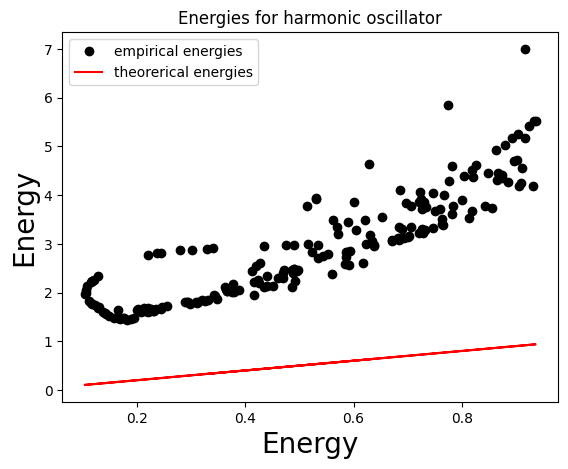

In [24]:
figure(8)
plot(E,E_emp,'ok')#  empirical
plot(E,E,'-r')#  theorerical
legend(["empirical energies","theorerical energies"])
xlabel("Energy",size=20)
ylabel("Energy",size=20)
title("Energies for harmonic oscillator")